## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [275]:
# Importing libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from collections import deque
%matplotlib inline

In [274]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([])
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

left_lane = Line()
right_lane = Line()

# Camera Calibration
Reference from: [here](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb)

In [238]:
def camera_calibration(nx = 6,ny = 9):
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('camera_cal/calibration*.jpg')
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny,nx), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    # Test undistortion on an image
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    retval, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    vis = np.concatenate((img, dst), axis=1)
    cv2.imwrite('output_images/calibration1_undist.jpg',vis)
    
    # Save the camera calibration result
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    outfile = open("cam_cal.p", "wb")
    pickle.dump(dist_pickle, outfile)
    outfile.close()
    return {"mtx":mtx, "dist":dist}

In [239]:
def cal_test(dist_pickle):
    images = glob.glob('test_images/*.jpg') 
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        dst = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])
        output_path = 'output_images/cal_test/cal_' + filename
        vis = np.concatenate((img, dst), axis=1)
        cv2.imwrite(output_path,vis)

# Gradient Filtering 

In [240]:
def abs_sobel_thresh(gray, axis, sobel_kernel=3, thresh=(20, 100)):
    if axis == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(gray)
    grad_binary[((scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1]))] = 1
    return grad_binary

def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled = np.uint8(255*abs_mag/np.max(abs_mag))
    # Apply threshold
    mag_binary = np.zeros_like(gray)
    mag_binary[((scaled > mag_thresh[0])&(scaled < mag_thresh[1]))] = 1
    return mag_binary

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_x = np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    direct = np.arctan2(abs_y, abs_x)
    binary_output = np.zeros_like(gray)
    binary_output[(direct > thresh[0]) & (direct < thresh[1])] = 1
    return binary_output

def filtering(ksize = 3, path='test_images/straight_lines1.jpg', img = None):
    if len(img) == 0:
        img = mpimg.imread(path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_gray = cv2.GaussianBlur(gray_image,(3,3),0)
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray_image, axis = 'x',sobel_kernel=ksize, thresh=(25, 200))
    dir_binary = dir_threshold(blur_gray, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/4 + 0.3))
    gradx_direct = np.zeros_like(gray_image)
    gradx_direct[(gradx == 1) & (dir_binary == 1)] = 1
    return gradx, dir_binary, gradx_direct

def filtering_test():
    images = glob.glob('test_images/*.jpg') 
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        gradx, dir_binary, gradx_dir = filtering(path = path)
        output_path_x = 'output_images/filter_test/gradx_' + filename
        output_path_dir = 'output_images/filter_test/dir_' + filename
        output_path_x_dir = 'output_images/filter_test/x_dir_' + filename
        cv2.imwrite(output_path_x,gradx)
        cv2.imwrite(output_path_dir,dir_binary)
        cv2.imwrite(output_path_x_dir,dir_binary)


In [241]:
cv2.destroyAllWindows()

# Color Filtering

In [242]:
def color_filtering(path='test_images/straight_lines1.jpg', img = None, thresh = (100,255)):
    if len(img) == 0:
        img = mpimg.imread(path)
    _, filename = os.path.split(path)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary
#     cv2.imwrite("output_images/color_test/" + filename, binary)
def color_test():
    images = glob.glob('test_images/*.jpg') 
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        S = color_filtering(path)
        output_path = 'output_images/color_test/' + filename
        cv2.imwrite(output_path,S)


# Masking

In [243]:
def mask_test():
    images = glob.glob('test_images/*.jpg')
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        half_height = img.shape[0] //2
        tuned_height = half_height + 95
        half_width = img.shape[1] //2
        left_top = (half_width - 50,tuned_height)
        left_bot = (185,img.shape[0])
        right_top = (half_width + 50,tuned_height)
        right_bot = (img.shape[1] - 145,img.shape[0])
        vertices = np.array([[left_bot,left_top,right_top,right_bot]], dtype=np.int32)
        img = region_of_interest(img,vertices)
        output_path = 'output_images/mask_test/'+ filename
        cv2.imwrite(output_path,img)
mask_test()

# Perspective transform 

In [244]:
def perspective_transform(img):
    img_size = (img.shape[1],img.shape[0])
    half_height = img.shape[0] //2
    tuned_height = half_height + 95
    half_width = img.shape[1] //2
    left_top = (half_width - 50,tuned_height)
    left_bot = (185,img.shape[0])
    right_top = (half_width + 50,tuned_height)
    right_bot = (img.shape[1] - 145,img.shape[0])
    src = np.float32([ right_top, right_bot, left_bot, left_top])
    offset = 250 # offset for dst points
    dst = np.float32([[img_size[0]-offset, offset], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]],
                      [offset, offset]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M
def p_test():
    images = glob.glob('test_images/*.jpg')
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        warped, _ = perspective_transform(img)
        output_path = 'output_images/perspective_transform/'+ filename
        cv2.imwrite(output_path,warped)

p_test()
        

44321 22582
(720, 1280, 3)
(44321,)


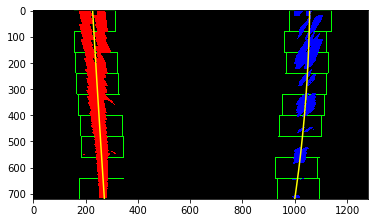

In [277]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox > win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox > win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    print(len(leftx),len(rightx))

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Colors in the left and right lane regions
    print(out_img.shape)
    print(lefty.shape)
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

images = glob.glob('output_images/pipeline_test/pt_straight_lines1.jpg') 
binary_warped = mpimg.imread(images[0])
out_img = fit_polynomial(binary_warped)
plt.imshow(out_img)

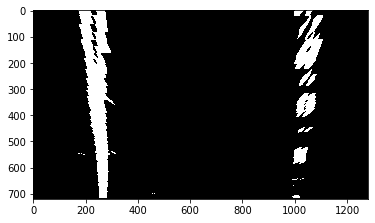

In [267]:
def pipeline_test():
    images = glob.glob('test_images/*.jpg') 
    #read in cal file or re-cal
    dist_pickle = {}
    try:
        infile = open("cam_cal.p",'rb')
        dist_pickle = pickle.load(infile)
    except:
        dist_pickle = camera_calibration()
        
    for path in images:
        img = cv2.imread(path)
        _, filename = os.path.split(path)
        
        # undistortion
        img = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])
        
        # gradient filtering
        gradx, dir_binary, gradx_direct = filtering(img = img, path = path)
        
        # color filtering
        S = color_filtering(img = img, path = path)
        
        # stack
        color = np.dstack(( np.zeros_like(gradx_direct), gradx_direct, S))
        
        # combine
        combined_binary = np.zeros_like(gradx_direct)
        combined_binary[(S == 1) | (gradx == 1)] = 1
        
        # perspective transform
        pt_binary, _ = perspective_transform(combined_binary)
        
        # output
        output_path_s = 'output_images/pipeline_test/s_' + filename
        output_path_x = 'output_images/pipeline_test/x_' + filename
        output_path_dir = 'output_images/pipeline_test/dir_' + filename
        output_path_x_dir = 'output_images/pipeline_test/x_dir_' + filename
        output_path_origin = 'output_images/pipeline_test/origin_' + filename
        output_path_color = 'output_images/pipeline_test/c_' + filename
        output_path_combined = 'output_images/pipeline_test/combined_' + filename
        output_path_pt = 'output_images/pipeline_test/pt_' + filename
        
#         vis = np.concatenate((img, combined_binary), axis=1)
#         cv2.imwrite(output_path_combined,vis)
        cv2.imwrite(output_path_s,S)
        cv2.imwrite(output_path_x,gradx)
        cv2.imwrite(output_path_dir,dir_binary)
        cv2.imwrite(output_path_x_dir,gradx_direct)
        cv2.imwrite(output_path_origin,img)
        cv2.imwrite(output_path_color,color)
        cv2.imwrite(output_path_pt,pt_binary)
        plt.imshow(pt_binary,cmap=plt.cm.gray)
pipeline_test()

In [190]:
def pipeline(img, dist_pickle):
    # undistortion
    img = cv2.undistort(img, dist_pickle["mtx"], dist_pickle["dist"], None, dist_pickle["mtx"])

    # gradient filtering
    gradx, _, _ = filtering(img = img, path = path)

    # color filtering
    S = color_filtering(img = img, path = path)

    # combine
    combined_binary = np.zeros_like(gradx)
    combined_binary[(S == 255) | (gradx == 255)] = 255
    combined_binary = np.dstack((combined_binary,combined_binary,combined_binary))

    # perspective transform
    pt_binary, _ = perspective_transform(combined_binary)
    